In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange

In [2]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LocallyConnected2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.utils import plot_model, to_categorical

import pandas as pd

Using TensorFlow backend.


In [3]:
df = pd.read_csv('fer2013/fer2013.csv')

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
def pullImage(frame, index: int):
  """
  Takes in a pandas data frame object and an index and returns the 48 x 48 pixel
  matrix as well as the label for the type of emotion.
  """
  img = frame.loc[index]['pixels'].split(' ')
  img = np.array([np.int(i) for i in img])
  img.resize(48,48)
  label = np.uint8(frame.loc[index]['emotion'])
  
  return img, label


def splitImage_Labels(frame):
  """
  Takes in a pandas data frame object filled with pixel field and label field 
  and returns two numpy arrays; one for images and one for labels.
  """
  labels = np.empty(len(frame))
  images = np.empty((len(frame), 48, 48, 1))  # using channel last notation.
  
  for i in range(len(frame)):
    img, lbl = pullImage(frame, i)
    img = np.reshape(img, (48,48,1))
    images[i], labels[i] = img, lbl
    
  return images.astype(np.uint8), to_categorical(labels, 7).astype(np.uint8)

In [6]:
df_Training = df[df.Usage == 'Training']
df_Testing = df[df.Usage == 'PrivateTest'].reset_index(drop = True)
df_Training.drop('Usage', axis=1, inplace=True)
df_Testing.drop('Usage', axis=1, inplace=True)

/home/ashu2_gamer/.local/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
img_train, lbl_train = splitImage_Labels(df_Training)
img_test, lbl_test = splitImage_Labels(df_Testing)

In [8]:
np.save('img_train.npy', img_train)
np.save('lbl_train.npy', lbl_train)
np.save('img_test.npy', img_test)
np.save('lbl_test.npy', img_test)

Text(0.5,1,'Training Image 40 (with label [1 0 0 0 0 0 0])')

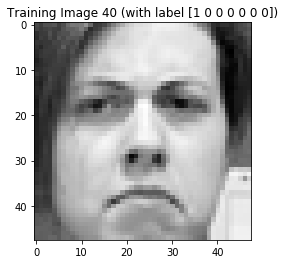

In [9]:
plt.imshow(np.reshape(img_train[40], (48,48)),cmap='gray' )
plt.title('Training Image 40 (with label ' + str(lbl_train[0]) + ')')

In [10]:
n_inputs = 2304
n_classes = 7
img_dim = 48

In [16]:
model = Sequential()

#part1 ------------------------------------------------------------------------------------------------------
outputFilters = 40
kernelSize = 5

model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu',
                 input_shape=img_train[0].shape))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))
#model.add(Dropout(0.2))
model.add(Conv2D(outputFilters, kernelSize, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

#part2 ------------------------------------------------------------------------------------------------------
outputFilters2 = 60
kernelSize2 = 5 

model.add(Conv2D(outputFilters2, kernelSize2, padding='same', activation='relu'))
model.add(Conv2D(outputFilters2, kernelSize2, padding='same', activation='relu'))
model.add(Conv2D(outputFilters2, kernelSize2, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

#part3 ------------------------------------------------------------------------------------------------------
outputFilters3 = 100
kernelSize3 = 3

model.add(LocallyConnected2D(outputFilters3, kernelSize3, padding='valid', activation='relu'))
model.add(LocallyConnected2D(outputFilters3, kernelSize3, padding='valid', activation='relu'))

#part4 ------------------------------------------------------------------------------------------------------
layerSize = 64

model.add(Flatten())
model.add(Dense(layerSize, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(layerSize, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
import time

start = time.time()
batchSize = 800
trainingEpochs = 50

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

trainingHistory = model.fit(img_train, lbl_train, batch_size=batchSize, 
                            epochs=trainingEpochs,
                            validation_split=0.3, 
                            callbacks=[early_stopping], 
                            shuffle=True,)

trainingAccuracy = trainingHistory.history['acc']
validationAccuracy = trainingHistory.history['val_acc']

end = time.time()
print("*Net Time : ", (end-start)/60, ' mins...')

Train on 20096 samples, validate on 8613 samples
Epoch 1/50
20096/20096 [==============================] - 25s 1ms/step - loss: 1.9240 - acc: 0.2100 - val_loss: 1.8477 - val_acc: 0.2529
Epoch 2/50
20096/20096 [==============================] - 21s 1ms/step - loss: 1.8431 - acc: 0.2375 - val_loss: 1.8136 - val_acc: 0.2529
Epoch 3/50
20096/20096 [==============================] - 21s 1ms/step - loss: 1.8038 - acc: 0.2476 - val_loss: 1.7626 - val_acc: 0.2587
Epoch 4/50
20096/20096 [==============================] - 21s 1ms/step - loss: 1.7542 - acc: 0.2852 - val_loss: 1.6884 - val_acc: 0.3511
Epoch 5/50
20096/20096 [==============================] - 21s 1ms/step - loss: 1.6852 - acc: 0.3308 - val_loss: 1.6622 - val_acc: 0.3813
Epoch 6/50
20096/20096 [==============================] - 21s 1ms/step - loss: 1.6301 - acc: 0.3508 - val_loss: 1.5352 - val_acc: 0.4110
Epoch 7/50
20096/20096 [==============================] - 21s 1ms/step - loss: 1.5753 - acc: 0.3785 - val_loss: 1.5626 - val_acc:

In [ ]:
def predict(mdl, img):
  emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  im = np.zeros((1, 48, 48, 1))
  im[0] = img
  p = mdl.predict(im)

  i = np.argmax(p)
  
  plt.imshow(np.reshape(img, (48,48)), cmap='gray')
  plt.title('Test Image (Predicted Label: ' + emotions[i] + ')')
  return p

In [ ]:
predict(model, img_test[222])

In [ ]:
scores = model.evaluate(img_test, lbl_test)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

In [ ]:
model.save('fer2013prep1.h5')
model.save_weights('fer2013_weightsprep1.h5')

In [ ]:
img_indx = 2005
sample = img_test[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(lbl_test[img_indx, :]), get_emotion(pred_cls)))

In [ ]:
import time

In [ ]:
time.time()